# EXPERIMENT 1
### The following notebook contains the code for Genre Classifcation Experiment. In this experiment the goal is to use an unsupervised learning algorithm (LDA) as a way to engineer features to aid in the supervised learning task of classifying documents according to genre.

e.g. building a classifier on top of a topic model 

In [54]:
import ISO_Networks as ISON
import datawrangler

import re
import string
import nltk
import pandas as pd

import matplotlib.pyplot as plt
import plotly
%matplotlib inline

# Gather Data From 3 Corpora

In [2]:
C, F, T =ISON.load_universe()

In [8]:
films = F.text.tolist()
television = T.text.tolist()

# LDA Trained Model
Load previously trained LDA models from CMU Movie Corpus.
### One of the things to consider here is how the model is trained ( different hyperparameters)
The first model was run 500 times without lemmatization
The second model was run 200 times with lemmatization

In [3]:
model_0, dictionary0=datawrangler.load_model('topic500i.model')
model_1, dictionary1=datawrangler.load_model('200_27_silver.model')

In [4]:
legend_0=datawrangler.topic_items(model_0,20)
legend_1=datawrangler.topic_items(model_1,20)

# Preprocess Film Documents 
The input data for acquired from the original data matrices and translated into a bag of words representation. The film_strip function gets rid of all forms of punctuation, stopwords and returns a lowercase lematized BoW

In [24]:
import string
import re
import collections

# Normalization

In [70]:
#stopwords
stop_words=ISON.stop_words()
lemma = nltk.wordnet.WordNetLemmatizer()

def film_strip(source):
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    out = regex.sub(' ', source)
    out =out.lower().split()
    film_strip=[lemma.lemmatize(token) for token in out if token not in stop_words]
    return film_strip


def word_distribution(bow):
    flatten = lambda l: [item for sublist in l for item in sublist]
    raw_word_soup=flatten(bow)
    word_counter = collections.Counter(raw_word_soup)

    return word_counter
    

In [83]:
# normalize screenplays
film_universe=[film_strip(screenplay) for screenplay in films]

In [106]:
F['normal'] = [' '.join(i) for i in film_universe]

In [108]:
F.normal

0       15 minute fade czech airline panning side plan...
1       2012 written emmerich kloser draft february 19...
2       30 minute written diliberti 12 11 09 loosely b...
3       48 hr unknown draft writer fade open country e...
4       rev 04 29 87 blue law screenplay pressfield sh...
5       window top top location location abyss abyss o...
6       air force window top top location location air...
7       alien early draft bannon alien project titled ...
8       alien iii screenplay fasano story fasano draft...
9       alien resurrection deep space silent black swe...
10      window top top location location alien alien d...
11      alien predator dark horse prod present alien p...
12      dark written elan mastai roesch fade dense dar...
13      fade city skyline establishing shot city skyli...
14      window top top location location title origina...
15      arctic blue lamanna fade boreal alaska aerial ...
16      armageddon fade blackness hint green earth lie...
17      army d

# Word distribution in corpora
Word distribution in corpora can reveal certain words that appear far too often to be of use much in the same way as other stop words.

## Might be a good idea to filter out some of the top occuring words for greater data granularity (reduce noise)

In [84]:
#calculate word distributions
film_word_distribution= word_distribution(film_universe)

         Word   Count
0        door  146864
1        hand  140291
2        room  129721
3        turn  115728
4         eye  104867
5        head  102876
6        cont  102430
7        open   98640
8        face   97028
9        time   96102
10        car   93411
11        cut   92715
12  continued   82879
13       move   74561
14       walk   73729
15       pull   72139
16      start   71220
17       take   67815
18      house   66840
19      close   64860


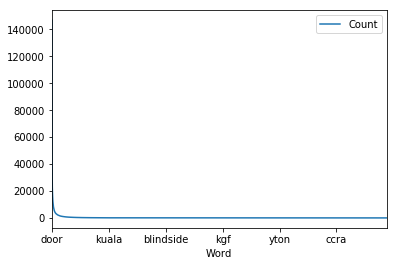

In [85]:
lst = film_word_distribution.most_common(2000000)
df = pd.DataFrame(lst, columns = ['Word', 'Count'])
df.plot(x='Word',y='Count')
print(df.head(20))

# Topic Discovery Film Corpus
Utilize preprocessed documents to project into the LDA MODEL. The ouput will be topic distributions to utilize as features later

In [49]:
#SAMPLE CODE 
# document_topics = model_0[dictionary0.doc2bow(film_reels[0])]
# exclude = [22,12]
# sorted_documents=sorted(document_topics, reverse=True, key = lambda x :x[1])[:7]
# top_topics=[j for j,_ in sorted_documents]
# theme_id = [t for t in top_topics if t not in exclude]
# theme= [legend_0[t] for t in top_topics if t not in exclude]

In [81]:
def film_analysis_model_0(film):
    document_topics = model_0[dictionary0.doc2bow(film)]
    exclude = set([24,21, 29,12])
    sorted_documents=sorted(document_topics, reverse=True, key = lambda x :x[1])[:10]
    top_topics=[j for j,_ in sorted_documents]
    theme_id = [t for t in top_topics if t not in exclude]
    theme= [legend_0[t] for t in top_topics if t not in exclude]
    
    return theme
    
def film_analysis_model_1(film):
    document_topics = model_1[dictionary1.doc2bow(film)]
    exclude = [22,12, 13,14]
    sorted_documents=sorted(document_topics, reverse=True, key = lambda x :x[1])[:10]
    top_topics=[j for j,_ in sorted_documents]
    theme_id = [t for t in top_topics if t not in exclude]
    theme= [legend_1[t] for t in top_topics if t not in exclude]
    
    return theme

In [77]:
film_theme0=[film_analysis_model_0(film) for film in film_reels]
film_theme1=[film_analysis_model_1(film) for film in film_reels]

In [165]:
srt=film_reels[0]

# Part Missing
    Still working on way to get LDA vector representation to feed into model below
        Need to figure out if gensim provides vector representation of topics already
            

# MACHINE LEARNING MODEL

## TO-DO
    # Find a way to concatenate topic-features with word-features
    #
    

In [87]:
# Machine Learning MODEL 
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn import linear_model, decomposition
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

In [94]:
# pipeline = Pipeline([
#     ('tfidf', TfidfVectorizer(stop_words=stop_words)),
#     ('clf', OneVsRestClassifier(LogisticRegression(solver='sag')))])

# parameters = {
#     'tfidf__max_df': (0.25, 0.5, 0.75),
#     'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
#     "clf__estimator__C": [0.01, 0.1, 1],
#     "clf__estimator__class_weight": ['balanced', None],
# }


In [137]:
data_x = F[['normal']].as_matrix()
data_y = F.drop(['name', 'text', 'normal'], axis=1).as_matrix()

In [150]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,
                                                    stratify=data_y, 
                                                    test_size=0.30, random_state =42)

In [151]:
train_x = [x[0].strip() for x in X_train.tolist()]
train_y = [x[0].strip() for x in y_train.tolist()]
test_x = [x[0].strip() for x in X_test.tolist()]
test_y = [x[0].strip() for x in y_test.tolist()]

In [154]:
len(test_x)

849

In [155]:
model = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,3), stop_words=stop_words)),
    ('clf', OneVsRestClassifier(LogisticRegression(solver ='sag')))
])


In [156]:
%time clf1=model.fit(train_x, train_y)

/Users/ViVeri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/ViVeri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



CPU times: user 41min 45s, sys: 1min 31s, total: 43min 17s
Wall time: 45min 37s


In [157]:
y_pred = clf1.predict(test_x)
print(classification_report( test_y, y_pred))
print((y_pred == y_test).mean())

             precision    recall  f1-score   support

     Action       0.00      0.00      0.00        87
  Adventure       0.00      0.00      0.00        50
  Animation       0.00      0.00      0.00        10
  Biography       0.00      0.00      0.00         1
     Comedy       0.00      0.00      0.00       104
      Crime       0.00      0.00      0.00        60
      Drama       0.19      0.57      0.29       174
     Family       0.00      0.00      0.00        12
    Fantasy       0.00      0.00      0.00        34
  Film-Noir       0.00      0.00      0.00         1
    History       0.00      0.00      0.00         1
     Horror       0.00      0.00      0.00        45
     Music1       0.00      0.00      0.00         1
     Music2       0.00      0.00      0.00         7
    Mystery       0.00      0.00      0.00        32
    Romance       0.00      0.00      0.00        58
     Sci-Fi       0.00      0.00      0.00        46
      Short       0.00      0.00      0.00   

/Users/ViVeri/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

